# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
1,1970-02-01,Feb,30.5
2,1970-03-01,Mar,46.0
3,1970-04-01,Apr,27.0
4,1970-05-01,May,0.0


In [4]:
df = df.query("Month == 'Jan'")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
12,1971-01-01,Jan,29.0
24,1972-01-01,Jan,32.2
36,1973-01-01,Jan,84.9
48,1974-01-01,Jan,87.5


In [5]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Month,Snow Fall
Date,,
1970-01-01,Jan,78.0
1971-01-01,Jan,29.0
1972-01-01,Jan,32.2
1973-01-01,Jan,84.9
1974-01-01,Jan,87.5


# All Data

## Plot

In [6]:
y = df["Snow Fall"]

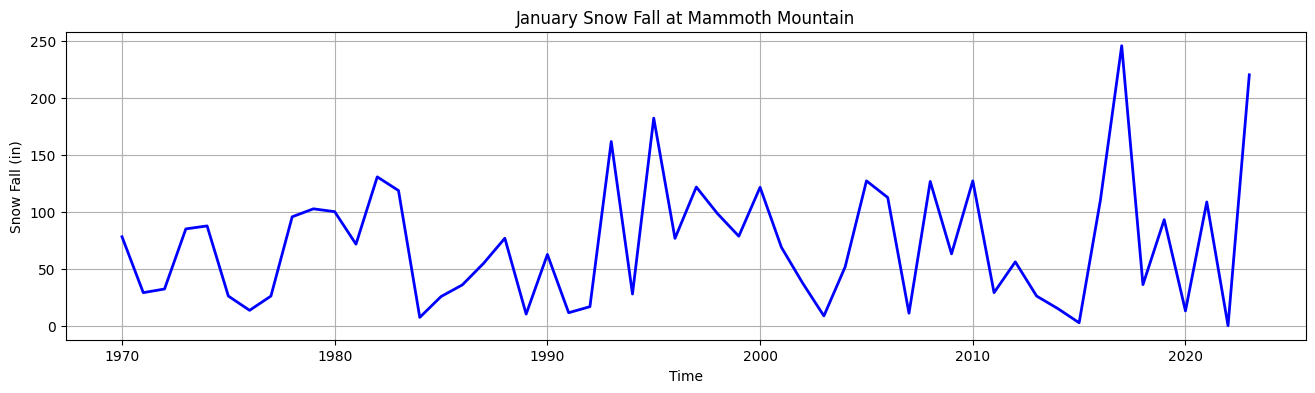

In [7]:
plt.figure(figsize=(16, 4))
plt.plot(y, color="blue", lw=2)
plt.title("January Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Snow Fall (in)")
plt.show()

In [8]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

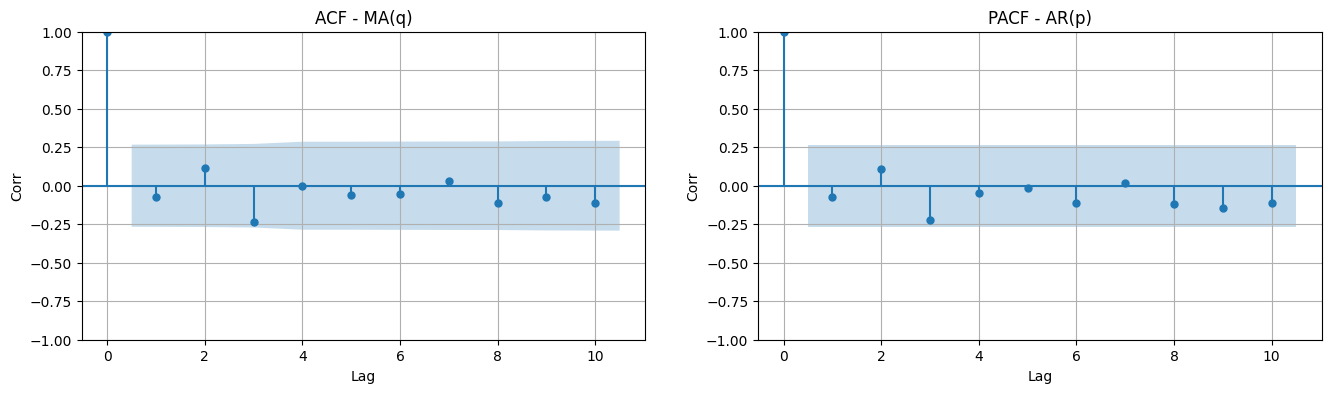

In [9]:
plot_acf_pacf(y)

In [10]:
display(adfuller(y))

(-7.234554476644024,
 1.9548952902069455e-10,
 0,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 465.8447688914782)

# Train / Test Split

In [11]:
y_target = y

In [12]:
n_steps_future = 6
(y_history, y_future) = train_test_split(
    y_target, shuffle=False, test_size=n_steps_future
)

In [13]:
(y_exog, y_exog_history, y_exog_future) = (None, None, None)

# Fit with ARIMA

In [14]:
def get_train_test_errors(y_target, y_hat, n_steps_future):
    (y_history, y_future, y_fit, y_forecast) = train_test_split(
        y_target, y_hat, shuffle=False, test_size=n_steps_future
    )

    mae_fit = mean_absolute_error(y_history, y_fit)
    rmse_fit = root_mean_squared_error(y_history, y_fit)

    mae_forecast = mean_absolute_error(y_future, y_forecast)
    rmse_forecast = root_mean_squared_error(y_future, y_forecast)

    return dict(
        zip(
            ["mae_fit", "rmse_fit", "mae_forecast", "rmse_forecast"],
            [mae_fit, rmse_fit, mae_forecast, rmse_forecast],
        )
    )

In [15]:
p_list = range(1, 4)
d_list = range(1, 3)
q_list = range(1, 4)

best_error = np.Inf
best_order_p_d_q = None

seasonal_order = (0, 0, 0, 0)

if 1:
    for p in p_list:
        for q in q_list:
            for d in d_list:
                order_p_d_q = (p, d, q)
                estimator = ARIMA(
                    y_history,
                    order=order_p_d_q,
                    seasonal_order=seasonal_order,
                    exog=y_exog_history,
                ).fit()

                # Compute all history, plus future forecast
                y_hat = estimator.predict(
                    start=y_target.index[0], end=y_target.index[-1], exog=y_exog_future
                )

                train_test_errors = get_train_test_errors(
                    y_target, y_hat, n_steps_future
                )

                if train_test_errors["rmse_forecast"] < best_error:
                    best_error = train_test_errors["rmse_forecast"]
                    best_order_p_d_q = order_p_d_q
                    print(
                        "New best at order_p_d_q = %s with errors:\n\t%s"
                        % (str(order_p_d_q), str(train_test_errors))
                    )

New best at order_p_d_q = (1, 1, 1) with errors:
	{'mae_fit': 43.89579732306398, 'rmse_fit': 54.23657867389602, 'mae_forecast': 65.67611198594552, 'rmse_forecast': 77.41462720278358}
New best at order_p_d_q = (1, 1, 2) with errors:
	{'mae_fit': 43.92887844291655, 'rmse_fit': 53.25625531637039, 'mae_forecast': 61.816839872654576, 'rmse_forecast': 74.83049592458633}
New best at order_p_d_q = (1, 2, 3) with errors:
	{'mae_fit': 48.11105572622031, 'rmse_fit': 58.12796724385531, 'mae_forecast': 61.03696306866001, 'rmse_forecast': 73.792022211751}


In [16]:
order_p_d_q = best_order_p_d_q
estimator = ARIMA(
    y_history, order=order_p_d_q, seasonal_order=seasonal_order, exog=y_exog_history
).fit()

y_hat = estimator.predict(
    start=y_target.index[0], end=y_target.index[-1], exog=y_exog_future
)
# display(estimator.summary())
train_test_errors = get_train_test_errors(y_target, y_hat, n_steps_future)
display(best_order_p_d_q)
display(train_test_errors)

(1, 2, 3)

{'mae_fit': 48.11105572622031,
 'rmse_fit': 58.12796724385531,
 'mae_forecast': 61.03696306866001,
 'rmse_forecast': 73.792022211751}

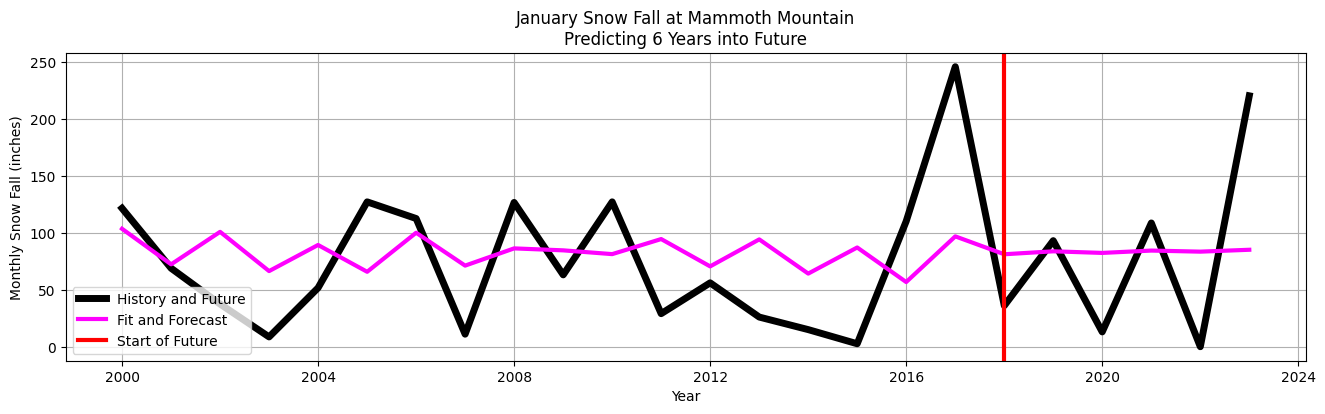

In [23]:
nplot = n_steps_future
nplot = 3 * n_steps_future
plt.figure(figsize=(16, 4))
# plt.plot(y_history.tail(nplot), color="black", label="History", lw=5)
# plt.plot(y_future, color="black", alpha=0.75, label="Future", lw=5)
plt.plot(
    y_target.tail(nplot + n_steps_future),
    color="black",
    label="History and Future",
    lw=5,
)
plt.plot(
    y_hat.tail(nplot + n_steps_future), color="magenta", label="Fit and Forecast", lw=3
)
plt.axvline(y_future.index[0], color="red", label="Start of Future", lw=3)
plt.title(
    "January Snow Fall at Mammoth Mountain\nPredicting %d Years into Future"
    % n_steps_future
)
plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="lower left")
plt.show()

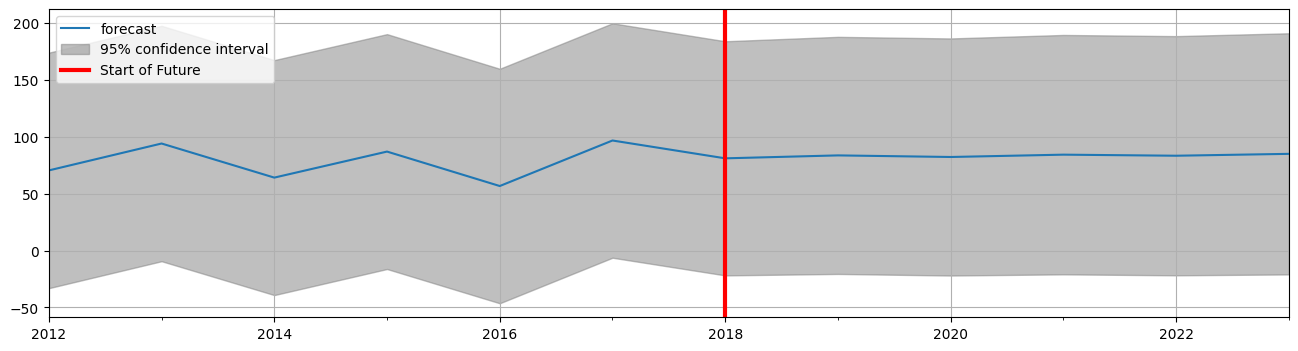

In [18]:
fig, ax = plt.subplots(figsize=(16, 4))
fig = plot_predict(
    estimator,
    start=y_history.tail(n_steps_future).index[0],
    end=y_future.index[-1],
    ax=ax,
    exog=y_exog_future,
)
plt.axvline(y_future.index[0], color="red", label="Start of Future", lw=3)
legend = ax.legend(loc="upper left")
plt.show()

## Plot Residue

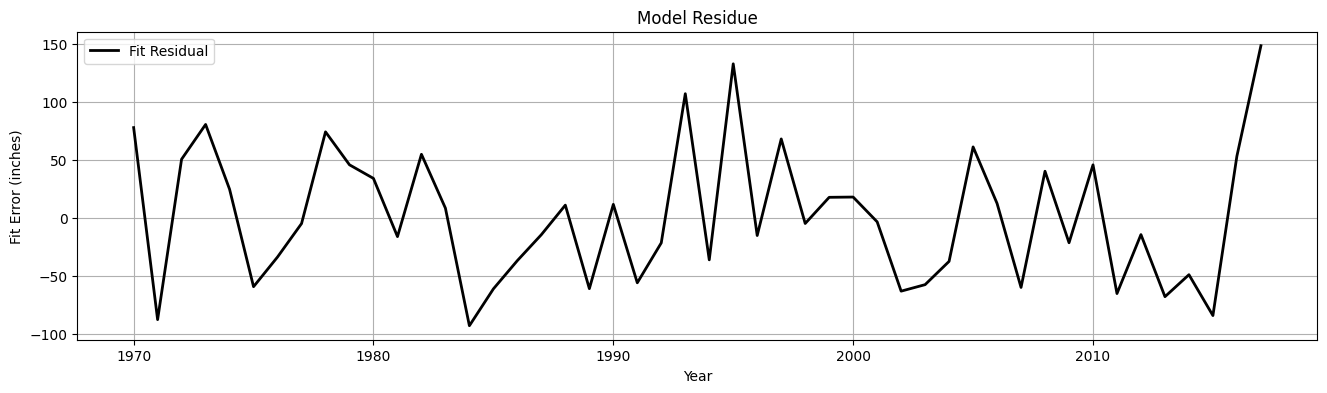

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(estimator.resid, color="black", lw=2, label="Fit Residual")
plt.title("Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.legend(loc="upper left")
plt.show()

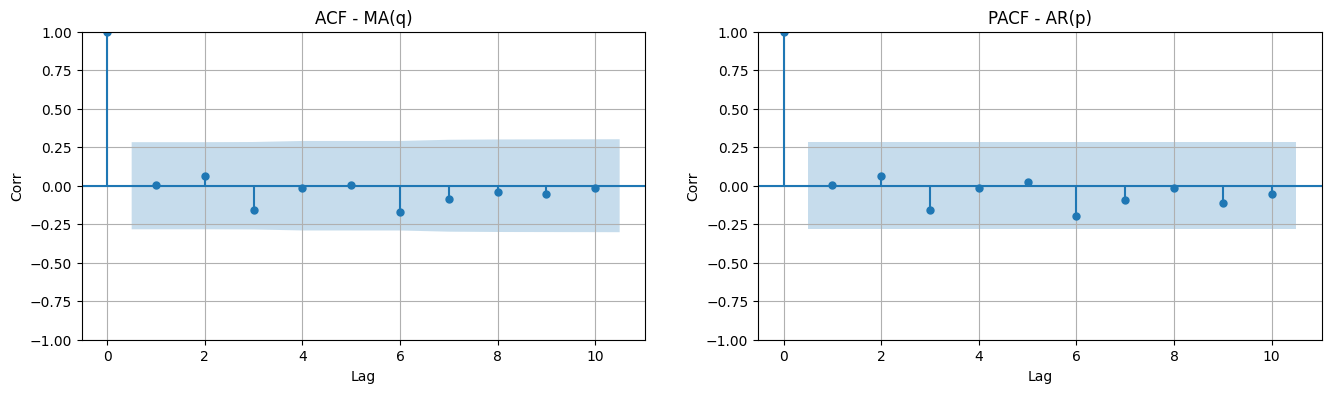

In [20]:
plot_acf_pacf(estimator.resid)

In [21]:
display(adfuller(estimator.resid))

(-6.311106373997103,
 3.233019232663022e-08,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 409.50461726715815)